In [1]:
import numpy as np
import gym
from gym import wrappers
import gym_custom_envs
import time as tt
from gekko import GEKKO
env = gym.make('Quadrotor2D-trajopt-v0', dt=0.01)
# env = gym.wrappers.Monitor(env, "vid", force=True)
m = GEKKO(remote=True)

In [2]:
mass = env.m
Inertia = env.I
gravity = env.gravity
r = env.l/2
length = env.l

In [3]:
T = 3
m.time = np.linspace(0,T,int(T/env.dt))

In [4]:
# Control Force
u1i = m.Var(value=mass*gravity, lb=-20*env.thrust_max, ub=20*env.thrust_max)
u2i = m.Var(value=mass*gravity, lb=-20*env.thrust_max, ub=20*env.thrust_max)

s = env.reset().reshape(6, 1)

#State Variables
xi = m.Var(value=s[0, 0], lb = -env.x_threshold, ub = env.x_threshold)
yi = m.Var(value=s[1, 0], lb = -env.y_threshold, ub = env.y_threshold)
thetai = m.Var(value=s[2, 0], lb = -env.O_threshold, ub = env.O_threshold)

dxi = m.Var(value=s[3, 0])
dyi = m.Var(value=s[4, 0])
dthetai = m.Var(value=s[5, 0])

In [5]:
#Defining the State Space Model
m.Equation(xi.dt() == dxi)
m.Equation(yi.dt() == dyi)
m.Equation(thetai.dt() == dthetai)

m.Equation(dxi.dt() == -((u1i + u2i)*m.sin(thetai)/mass))
m.Equation(dyi.dt() == (((u1i + u2i)*m.cos(thetai) - (mass*gravity))/mass))
m.Equation(dthetai.dt() == ((u1i - u2i)*r/Inertia))


In [6]:
# Definine the Objectives
# Make all the state variables be zero at time >= 2.2
# m.Obj(xi**2)
# m.Obj(yi**2)
# m.Obj(thetai**2)
m.fix(xi, pos=len(m.time) - 1, val=0)
m.fix(yi, pos=len(m.time) - 1, val=0)
m.fix(thetai, pos=len(m.time) - 1, val=0)
m.fix(dxi, pos=len(m.time) - 1, val=0)
m.fix(dyi, pos=len(m.time) - 1, val=0)
m.fix(dthetai, pos=len(m.time) - 1, val=0)
# m.Obj(dyi**2)
# m.Obj(dxi**2)
# m.Obj(dthetai**2)
#Try to minimize change of MV over all horizon
m.Obj(u1i**2)
m.Obj(u2i**2)
m.fix(u1i, pos=len(m.time) - 1, val=mass*gravity/2)
m.fix(u2i, pos=len(m.time) - 1, val=mass*gravity/2)

In [7]:
m.options.IMODE = 6 # MPC
# m.options.SOLVER = 3
m.solve() #(disp=False)

apm 106.206.74.222_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            8
   Intermediates:            0
   Connections  :           16
   Equations    :            8
   Residuals    :            8
 
 Number of state variables:           4172
 Number of total equations: -         3588
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            584
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipo

<IPython.core.display.Javascript object>


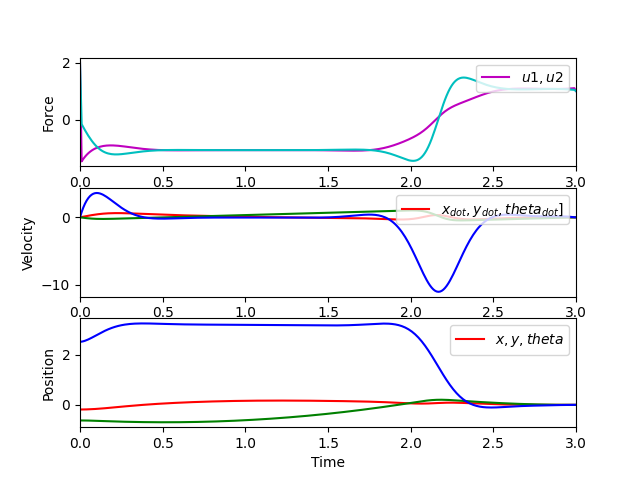

(0.0, 3.0)

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.subplot(311)
plt.plot(m.time,u2i.value,'m', m.time, u1i.value,'c')
plt.legend([r'$u1, u2$'],loc=1)
plt.ylabel('Force')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(312)
plt.plot(m.time,dxi.value,'r', m.time, dyi.value,'g', m.time,dthetai.value,'b')
plt.legend([r'$x_{dot}, y_{dot}, theta_{dot}]$'],loc=1)
plt.ylabel('Velocity')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(313)
plt.plot(m.time,xi.value,'r', m.time, yi.value,'g', m.time,thetai.value,'b',)
plt.legend([r'$x, y, theta$'],loc=1)
plt.ylabel('Position')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

In [9]:
done = False
j = 0
while not done:
    a = [xi.value[j], yi.value[j], thetai.value[j], 
         dxi.value[j], dyi.value[j], dthetai.value[j],
         u1i.value[j], u2i.value[j]]
    ns, c, done,_ = env.step(a)
    s = ns.reshape(6, 1)
    env.render()
    j += 1
env.close()